<a href="https://colab.research.google.com/github/tmskss/ManPageSum/blob/main/colab/finetune_flan_t5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Flan-T5 base
This notebook is used to fine-tune a pre-trained [flan-t5-base](https://huggingface.co/google/flan-t5-base) model for summarization using the [linux-man-pages-tldr-summarized](https://huggingface.co/datasets/tmskss/linux-man-pages-tldr-summarized) dataset.

In [1]:
!git clone https://github.com/tmskss/ManPageSum.git
%cd ManPageSum/colab
from install import *
install_requirements()

Cloning into 'ManPageSum'...
remote: Enumerating objects: 1214, done.
remote: Counting objects: 100% (1214/1214), done.
remote: Compressing objects: 100% (935/935), done.
remote: Total 1214 (delta 295), reused 1189 (delta 278), pack-reused 0
Receiving objects: 100% (1214/1214), 9.21 MiB | 3.56 MiB/s, done.
Resolving deltas: 100% (295/295), done.
/content/ManPageSum/colab
⏳ Installing base requirements ...
✅ Base requirements installed!
✅ Summary requirements installed!


In [2]:
from utils import *
setup_chapter()

Using transformers v4.32.1
Using datasets v2.0.0


## Get the dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("tmskss/linux-man-pages-tldr-summarized")
print(f"Features: {dataset['train'].column_names}")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/tmskss--linux-man-pages-tldr-summarized-ae8bc80ae0d1d6c6/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


/usr/local/lib/python3.10/dist-packages/datasets/packaged_modules/csv/csv.py:154: FutureWarning: the 'mangle_dupe_cols' keyword is deprecated and will be removed in a future version. Please take steps to stop the use of 'mangle_dupe_cols'
  csv_file_reader = pd.read_csv(file, iterator=True, dtype=dtype, **self.config.read_csv_kwargs)


  0%|          | 0/1 [00:00<?, ?it/s]

Features: ['Command', 'Text', 'Summary']


Split the data randomly. 10% goes to validation.

In [4]:
import random

def create_validation_split(dataset, validation_percent=0.1):

    # Calculate the number of rows for the validation set
    num_validation_samples = int(len(dataset['train']) * validation_percent)

    # Randomly shuffle the dataset
    shuffled_indices = list(range(len(dataset['train'])))
    random.shuffle(shuffled_indices)

    # Select rows for the validation set
    validation_indices = shuffled_indices[:num_validation_samples]
    validation_data = [dataset['train'][i] for i in validation_indices]

    # Remove validation rows from the original dataset
    training_data = [dataset['train'][i] for i in shuffled_indices[num_validation_samples:]]

    dataset['validation'] = validation_data

    return dataset

In [5]:
dataset = create_validation_split(dataset)

print('The dataset has {} rows of training data and {} rows of validation data'.format(len(dataset['train']), len(dataset['validation'])))

The dataset has 481 rows of training data and 48 rows of validation data


## Fine-tune the model

In [6]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base", device_map="auto")

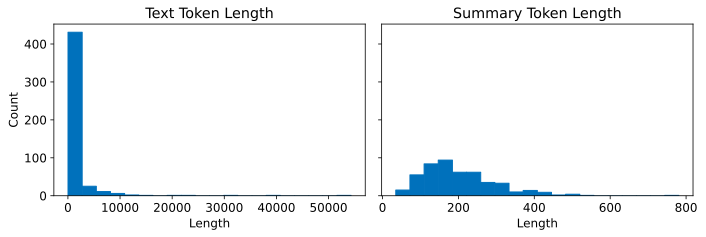

In [7]:
d_len = [len(tokenizer.encode(s)) for s in dataset["train"]["Text"]]
s_len = [len(tokenizer.encode(s)) for s in dataset["train"]["Summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Text Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [26]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["Text"], max_length=1024,
                                truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["Summary"], max_length=512,
                                     truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_pt_train = dataset['train'].map(convert_examples_to_features,
                                       batched=True)
dataset_pt_eval = dataset['train'].map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_pt_train.set_format(type="torch", columns=columns)
dataset_pt_eval.set_format(type="torch", columns=columns)

  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3660: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

In [9]:
from huggingface_hub import notebook_login

notebook_login()

In [27]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Training arguments were chosen from the [original paper](https://arxiv.org/pdf/2210.11416.pdf), from Table 22.

In [31]:
from transformers import TrainingArguments, Trainer

finetuned_model_ckpt = 'flan-t5-base-finetuned-linux-man-page-summarization'
batch_size = 16
learning_rate = 5e-4

training_args = TrainingArguments(
    output_dir=finetuned_model_ckpt,
    num_train_epochs=15,
    per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size,
    learning_rate=learning_rate,
    weight_decay=0.01,
    push_to_hub=True,
    evaluation_strategy='epoch')

In [32]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_pt_train,
                  eval_dataset=dataset_pt_eval)

In [ ]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries(dataset, metric, model, tokenizer,
                               batch_size=8, device=device,
                               column_text="Text",
                               column_summary="Summary"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for text_batch, target_batch in tqdm(
        zip(text_batches, target_batches), total=len(text_batches)):

        inputs = tokenizer(text_batch, max_length=512,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=512)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

In [35]:
trainer.train()

{'eval_loss': 0.5109121799468994, 'eval_runtime': 15.7889, 'eval_samples_per_second': 30.464, 'eval_steps_per_second': 7.664, 'epoch': 1.0}
{'eval_loss': 0.36843934655189514, 'eval_runtime': 15.7943, 'eval_samples_per_second': 30.454, 'eval_steps_per_second': 7.661, 'epoch': 2.0}
{'eval_loss': 0.2758232057094574, 'eval_runtime': 15.8167, 'eval_samples_per_second': 30.411, 'eval_steps_per_second': 7.65, 'epoch': 3.0}
{'eval_loss': 0.19685053825378418, 'eval_runtime': 15.8058, 'eval_samples_per_second': 30.432, 'eval_steps_per_second': 7.655, 'epoch': 4.0}
{'loss': 0.635, 'learning_rate': 0.00036225895316804407, 'epoch': 4.13}
{'eval_loss': 0.1499115228652954, 'eval_runtime': 15.8056, 'eval_samples_per_second': 30.432, 'eval_steps_per_second': 7.656, 'epoch': 5.0}
{'eval_loss': 0.11098846793174744, 'eval_runtime': 15.7911, 'eval_samples_per_second': 30.46, 'eval_steps_per_second': 7.663, 'epoch': 6.0}
{'eval_loss': 0.0807095468044281, 'eval_runtime': 15.7921, 'eval_samples_per_second': 3

TrainOutput(global_step=1815, training_loss=0.2992662971013177, metrics={'train_runtime': 992.0972, 'train_samples_per_second': 7.272, 'train_steps_per_second': 1.829, 'train_loss': 0.2992662971013177, 'epoch': 15.0})

In [36]:
trainer.push_to_hub("first finetune")

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

'https://huggingface.co/tmskss/flan-t5-linux-man-pages/tree/main/'

In [42]:
from transformers import pipeline
import nltk
from nltk.tokenize import sent_tokenize

#nltk.download("punkt")

pipe = pipeline("text2text-generation", model="tmskss/flan-t5-linux-man-pages")
pipe_out = pipe('summarize: ' + dataset['train'][6]['Text'])
print("\n".join(sent_tokenize(pipe_out[0]["generated_text"])))

# tcpdump > Dump traffic on a network.
More information:
